In [ ]:
#Import necessary libraries

import re
import os
import requests
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
# sns.set_style("whitegrid")
sns.set_style("darkgrid")

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types

## Define Work directory and data directory

In [ ]:
root_dir = "C:\Desktop\cps-analysis"
data_dir = "C:\Desktop\cps-analysis\data"

In [ ]:
os.chdir("C:\Desktop\cps-analysis\data")

In [ ]:
#Download data dictionary
!wget https://www2.census.gov/programs-surveys/cps/datasets/2017/basic/January_2017_Record_Layout.txt

--2022-09-15 02:07:13--  https://www2.census.gov/programs-surveys/cps/datasets/2017/basic/January_2017_Record_Layout.txt
Resolving www2.census.gov (www2.census.gov)... 104.86.249.71, 2600:1406:1a:188::208c, 2600:1406:1a:192::208c
Connecting to www2.census.gov (www2.census.gov)|104.86.249.71|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘January_2017_Record_Layout.txt’

January_2017_Record     [  <=>               ] 102.22K   345KB/s    in 0.3s    

2022-09-15 02:07:14 (345 KB/s) - ‘January_2017_Record_Layout.txt’ saved [104678]



In [ ]:
#Download responders data
!wget https://www2.census.gov/programs-surveys/cps/datasets/2017/basic/dec17pub.zip

--2022-09-15 02:07:19--  https://www2.census.gov/programs-surveys/cps/datasets/2017/basic/dec17pub.zip
Resolving www2.census.gov (www2.census.gov)... 104.86.249.71, 2600:1406:1a:188::208c, 2600:1406:1a:192::208c
Connecting to www2.census.gov (www2.census.gov)|104.86.249.71|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘dec17pub.zip’

dec17pub.zip            [<=>                 ]  12.12M   822KB/s    in 16s     

2022-09-15 02:07:36 (790 KB/s) - ‘dec17pub.zip’ saved [12707013]



In [ ]:
#Unzip the file in the data folder
!unzip dec17pub.zip

Archive:  dec17pub.zip
  inflating: dec17pub.dat            


In [ ]:
!ls

dec17pub.dat  dec17pub.zip  January_2017_Record_Layout.txt  Q1.png  Q-2.png


In [ ]:
spark = SparkSession\
          .builder \
          .master("local[*]") \
          .appName('cps') \
          .getOrCreate()

Read the data with spark

In [ ]:
data = spark.read.csv(os.path.join(data_dir,"dec17pub.dat"))

In [ ]:
data.show(10, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# !pip install dataframe-image

## Define a function to process Data Dictionary

In [ ]:
def get_data_dictionary(data_dir: str, filename: str, col_names: list):
  """
  Get the data dictionary file to be used to extract the required columns 
  from CPS data

  Args:
      data_dir (str): The directory to the data
      filename (str): The dictionary filename
      col_name (list): The list of columns to extract from the CPS data

  Returns:
      dict_data (Spark DataFrame)
  """

  with open(os.path.join(data_dir,filename), mode='r' ,encoding='cp1252') as f:
      data_dict = f.read()
      
  # regex expression pattern needed to extract info of the data dictionary file
  regex_pattern = re.compile('\n(\w+)\s+(\d+)\s+(.*?)\t+.*?(\d\d*).*?(\d\d+)')
  list_doc_data = regex_pattern.findall(data_dict)
  dict_col = ['name', 'size', 'description', 'start', 'end']
  dict_data = spark.createDataFrame(list_doc_data, dict_col)
  dict_data = dict_data.filter(dict_data.name.isin(col_names))

  return dict_data

## Define a function to read the encoding and decoding values

In [ ]:
def get_decode_values(root_dir: str, folder_name: str):
  """
  Get the encoded values from their respective files and read them into a 
  dictionary

  Args:
      root_dir (str): the root directory
      folder (str): the folder of the encoded files

  Returns:
      values_dict (dict): the dictionaries encoded decoded values
  """
  
  values_dict = {}
  files_dir = os.path.join(root_dir,folder_name)
  for filename in  os.listdir(files_dir):
      with open(os.path.join(files_dir, filename), mode='r') as f:
          val_data = f.read()

      # regrex pattern to extract from text files
      pattern = re.compile('(\d+)\s+(.+)', re.MULTILINE)
      list_data = pattern.findall(val_data)
      values_dict[filename.split(".")[0]] = dict(list_data)
  
  return values_dict

In [ ]:
#The columns needed to be extracted
col_data = [
    'HRHHID','HRHHID2', 'HRMONTH', 'HRYEAR4', 'HUFINAL', 'HEHOUSUT', 'HETELHHD',
    'HETELAVL', 'HEPHONEO', 'HEFAMINC', 'HRHTYPE', 'HUINTTYP', 'GEDIV','PTDTRACE'
    ]

In [ ]:
data_dict = get_data_dictionary(
    data_dir,
    "January_2017_Record_Layout.txt",
    col_data
    )

In [ ]:
#Using the data dictionary to create the columns that are needed
for row in data_dict.collect():
  data = data.withColumn(row.name, F.substring("_c0", int(row.start),int(row.size)))

In [ ]:
data.show(10)

+--------------------+---------------+-------+-------+-------+--------+--------+--------+--------+--------+-------+--------+-------+-----+--------+
|                 _c0|         HRHHID|HRMONTH|HRYEAR4|HUFINAL|HEHOUSUT|HETELHHD|HETELAVL|HEPHONEO|HEFAMINC|HRHTYPE|HUINTTYP|HRHHID2|GEDIV|PTDTRACE|
+--------------------+---------------+-------+-------+-------+--------+--------+--------+--------+--------+-------+--------+-------+-----+--------+
|00000479511071912...|000004795110719|     12|   2017|    201|       1|       1|      -1|       1|       9|      1|       2|  06011|    6|       1|
|00000479511071912...|000004795110719|     12|   2017|    201|       1|       1|      -1|       1|       9|      1|       2|  06011|    6|       1|
|00007169100494112...|000071691004941|     12|   2017|    201|       1|       1|      -1|       1|      11|      1|       1|  06111|    6|       1|
|00007169100494112...|000071691004941|     12|   2017|    201|       1|       1|      -1|       1|      11|     

## Data Preparation

In [ ]:
data = data.withColumn('full household id', F.concat(F.col('HRHHID'), F.col('HRHHID2')))\
      .withColumn("PTDTRACE", F.regexp_replace(F.col('PTDTRACE'), " ", "0"))\
      .withColumn("HUFINAL", F.regexp_replace(F.col('HUFINAL'), " ","0"))\
      .withColumn('HEHOUSUT', F.regexp_replace(F.col('HEHOUSUT'), " ", ""))\
      .withColumn('HETELHHD', F.regexp_replace(F.col('HETELHHD'), " ", ""))\
      .withColumn('HETELAVL', F.regexp_replace(F.col('HETELAVL'), " ", ""))\
      .withColumn('HEPHONEO', F.regexp_replace(F.col('HEPHONEO'), " ", ""))\
      .withColumn('HEFAMINC', F.regexp_replace(F.col('HEFAMINC'), " ", ""))\
      .withColumn('HRHTYPE', F.regexp_replace(F.col('HRHTYPE'), " ", ""))\
      .withColumn('HUINTTYP', F.regexp_replace(F.col('HUINTTYP'), " ", ""))\
      .withColumn('GEDIV', F.regexp_replace(F.col('GEDIV'), " ", ""))\
      .withColumn('interview date', F.date_format(F.concat_ws('-',F.col('HRYEAR4')
                                    ,F.col('HRMONTH')).cast("date"),"yyyy/MMM"))\
      .select(['full household id', 'interview date', 'HUFINAL', 'HEHOUSUT',
               'HRHTYPE', 'HETELHHD', 'HETELAVL', 'HEPHONEO', 'HUINTTYP', 
               'HEFAMINC', 'GEDIV', 'PTDTRACE'])
# data.show()

In [ ]:
#Decoding the encoded values
values_dict = get_decode_values(root_dir, "decoding_values")

for key, val in values_dict.items():
  decode_func =  F.udf(lambda x: val.get(x, x), types.StringType())
  data = data.withColumn(key, decode_func(F.col(key)))

In [ ]:
data.show(10)

+--------------------+--------------+----------------+--------------------+--------------------+--------+--------+--------+---------+----------------+------------------+----------+
|   full household id|interview date|         HUFINAL|            HEHOUSUT|             HRHTYPE|HETELHHD|HETELAVL|HEPHONEO| HUINTTYP|        HEFAMINC|             GEDIV|  PTDTRACE|
+--------------------+--------------+----------------+--------------------+--------------------+--------+--------+--------+---------+----------------+------------------+----------+
|00000479511071906011|      2017/Dec|   CAPI COMPLETE|HOUSE, APARTMENT,...|HUSBAND/WIFE PRIM...|     YES|      -1|     YES|TELEPHONE|30,000 TO 34,999|EAST SOUTH CENTRAL|White Only|
|00000479511071906011|      2017/Dec|   CAPI COMPLETE|HOUSE, APARTMENT,...|HUSBAND/WIFE PRIM...|     YES|      -1|     YES|TELEPHONE|30,000 TO 34,999|EAST SOUTH CENTRAL|White Only|
|00007169100494106111|      2017/Dec|   CAPI COMPLETE|HOUSE, APARTMENT,...|HUSBAND/WIFE PRIM...

In [ ]:
#Renaming the columns
new_cols = [
    'full household id', 'interview date',
    'final outcome', 'type of housing unit', 
    'household type', 'household has telephone',
    'household can access telephone elsewhere',
    'is telephone interview acceptable',
    'type of interview ', 'family income range',
    'geographical division', 'race']
for old_c, new_c in zip(data.columns, new_cols):
  data = data.withColumnRenamed(old_c, new_c)

In [ ]:
data.show(10)

+--------------------+--------------+----------------+--------------------+--------------------+-----------------------+----------------------------------------+---------------------------------+------------------+-------------------+---------------------+----------+
|   full household id|interview date|   final outcome|type of housing unit|      household type|household has telephone|household can access telephone elsewhere|is telephone interview acceptable|type of interview |family income range|geographical division|      race|
+--------------------+--------------+----------------+--------------------+--------------------+-----------------------+----------------------------------------+---------------------------------+------------------+-------------------+---------------------+----------+
|00000479511071906011|      2017/Dec|   CAPI COMPLETE|HOUSE, APARTMENT,...|HUSBAND/WIFE PRIM...|                    YES|                                      -1|                              YES| 

In [ ]:
#Use document to replace missing/unaccepted values 
#https://www2.census.gov/programs-surveys/cps/methodology/PublicUseDocumentation_final.pdf
other_encode_values = {
    "-1":"Blank",
    "-2":"Don't Know",
    "-3":"Refused"
}
data = data.replace(other_encode_values)

In [ ]:
data.show(10)

+--------------------+--------------+----------------+--------------------+--------------------+-----------------------+----------------------------------------+---------------------------------+------------------+-------------------+---------------------+----------+
|   full household id|interview date|   final outcome|type of housing unit|      household type|household has telephone|household can access telephone elsewhere|is telephone interview acceptable|type of interview |family income range|geographical division|      race|
+--------------------+--------------+----------------+--------------------+--------------------+-----------------------+----------------------------------------+---------------------------------+------------------+-------------------+---------------------+----------+
|00000479511071906011|      2017/Dec|   CAPI COMPLETE|HOUSE, APARTMENT,...|HUSBAND/WIFE PRIM...|                    YES|                                   Blank|                              YES| 

In [ ]:
data.count(), len(data.columns)

(146456, 12)

In [ ]:
#Create spark tempoary view table 
data.createOrReplaceTempView("cps_data")

## Total Number of Responders

In [ ]:
spark.sql("""
SELECT 
  count(*) as `count of responders`
FROM cps_data
""").show()

+-------------------+
|count of responders|
+-------------------+
|             146456|
+-------------------+



## Total Distinct Households

In [ ]:
spark.sql("""
SELECT 
  count(distinct `full household id`) as `count of unique responders`
FROM cps_data
""").show()

+--------------------------+
|count of unique responders|
+--------------------------+
|                     72328|
+--------------------------+



## Q1: What is the count of responders per family income range (show top 10)?

In [ ]:
responder_by_family_income = spark.sql("""
SELECT 
  `family income range`, 
  count(`full household id`) as `count of responders`
FROM cps_data
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10
""")

responder_by_family_income.show()

+-------------------+-------------------+
|family income range|count of responders|
+-------------------+-------------------+
|              Blank|              20391|
| 100,000 TO 149,999|              17794|
|   75,000 TO 99,999|              16557|
|    150,000 OR MORE|              15704|
|   60,000 TO 74,999|              13442|
|   50,000 TO 59,999|               9971|
|   40,000 TO 49,999|               9788|
|   30,000 TO 34,999|               6743|
|   35,000 TO 39,999|               6620|
|   20,000 TO 24,999|               6312|
+-------------------+-------------------+



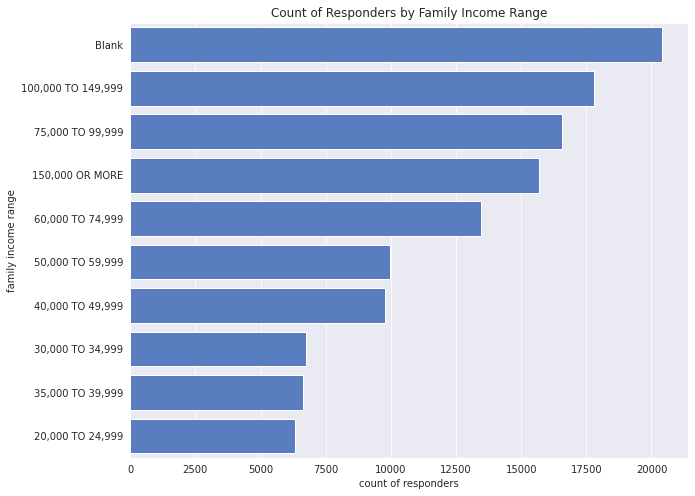

In [ ]:
sns.set_color_codes("muted")
plt.figure(figsize=(10,8))
sns.barplot(
    data=responder_by_family_income.toPandas(),
    x='count of responders',
    y='family income range',
    color='b')
plt.title("Count of Responders by Family Income Range")
plt.savefig("Q1.png", dpi=300)
plt.show()

## Q2: What is the count of responders per geographical division/location and race (show top 10)?

In [ ]:
responders_by_geo_division_race = spark.sql("""
SELECT 
  `geographical division`, `race`, 
  count(`full household id`) as `count of responders`
FROM cps_data
GROUP BY 1,2
ORDER BY 3 DESC
LIMIT 10
""")
responders_by_geo_division_race.show(truncate=False)

+---------------------+----------+-------------------+
|geographical division|race      |count of responders|
+---------------------+----------+-------------------+
|SOUTH ATLANTIC       |White Only|16999              |
|MOUNTAIN             |White Only|14343              |
|PACIFIC              |White Only|13214              |
|EAST NORTH CENTRAL   |White Only|11325              |
|WEST SOUTH CENTRAL   |White Only|11248              |
|WEST NORTH CENTRAL   |White Only|9884               |
|MIDDLE ATLANTIC      |White Only|8487               |
|NEW ENGLAND          |White Only|8410               |
|EAST SOUTH CENTRAL   |White Only|6580               |
|SOUTH ATLANTIC       |Black Only|4899               |
+---------------------+----------+-------------------+



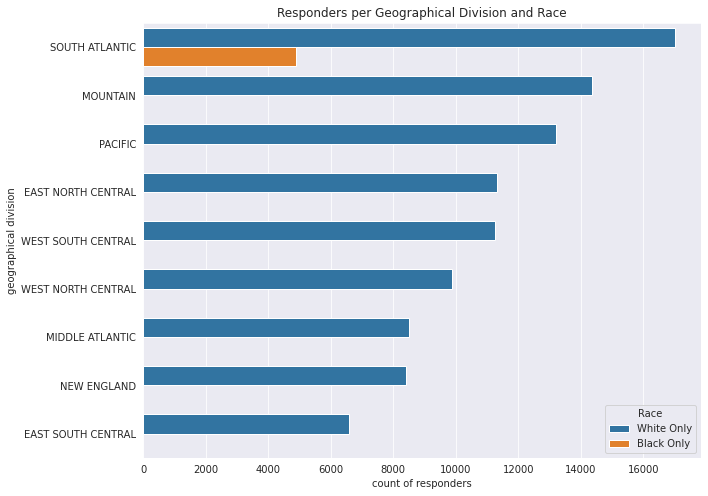

In [ ]:
plt.figure(figsize=(10,8))
sns.barplot(
    data=responders_by_geo_division_race.toPandas(),
    x='count of responders',
    y='geographical division',
    hue='race'
)
plt.legend(loc='lower right', title='Race')
plt.title("Responders per Geographical Division and Race")
plt.savefig("Q-2.png", dpi=300)
plt.show()

## How many responders do not have telephone in their house, but can access a telephone elswhere and telephone interview is accepted (show top 10)?

In [ ]:
spark.sql("""
SELECT COUNT(*) AS `Count of Responders`
FROM cps_data
WHERE `household has telephone`='NO' AND 
  `household can access telephone elsewhere`='YES' AND
  `is telephone interview acceptable`='YES'
""").show()

+-------------------+
|Count of Responders|
+-------------------+
|                633|
+-------------------+



## How many responders can access a telephone but telephone interview is not accepted (show top 10)?

In [ ]:
spark.sql("""
SELECT COUNT(*) AS `Count of Responders`
FROM cps_data
WHERE (`household has telephone`='YES' OR 
  `household can access telephone elsewhere`='YES') AND
  `is telephone interview acceptable`='NO'
""").show()

+-------------------+
|Count of Responders|
+-------------------+
|                  0|
+-------------------+

